In [2]:
import numpy as np # math functions
import scipy # scientific functions
import matplotlib.pyplot as plt # for plotting figures and setting their properties
import pandas as pd # handling data structures (loaded from files)
import scipy.constants as spc
from scipy import stats
from scipy.stats import linregress # contains linregress (for linear regression)
from scipy.optimize import curve_fit as cfit # non-linear curve fitting
from sklearn.metrics import r2_score # import function that calculates R^2 score 

Potential:

In [4]:
version = scipy.version.version

print(version)

1.9.3


In [5]:
C = 1
a = 1
L = 3
N = 100
coord = np.linspace(-L, L , N) # defines coordinates
coord_x, coord_y = np.meshgrid(coord, coord) 
print("coord = ", coord)
print("coord_x = ",coord_x)
print("coord_y = ",coord_y)

coord =  [-3.         -2.93939394 -2.87878788 -2.81818182 -2.75757576 -2.6969697
 -2.63636364 -2.57575758 -2.51515152 -2.45454545 -2.39393939 -2.33333333
 -2.27272727 -2.21212121 -2.15151515 -2.09090909 -2.03030303 -1.96969697
 -1.90909091 -1.84848485 -1.78787879 -1.72727273 -1.66666667 -1.60606061
 -1.54545455 -1.48484848 -1.42424242 -1.36363636 -1.3030303  -1.24242424
 -1.18181818 -1.12121212 -1.06060606 -1.         -0.93939394 -0.87878788
 -0.81818182 -0.75757576 -0.6969697  -0.63636364 -0.57575758 -0.51515152
 -0.45454545 -0.39393939 -0.33333333 -0.27272727 -0.21212121 -0.15151515
 -0.09090909 -0.03030303  0.03030303  0.09090909  0.15151515  0.21212121
  0.27272727  0.33333333  0.39393939  0.45454545  0.51515152  0.57575758
  0.63636364  0.6969697   0.75757576  0.81818182  0.87878788  0.93939394
  1.          1.06060606  1.12121212  1.18181818  1.24242424  1.3030303
  1.36363636  1.42424242  1.48484848  1.54545455  1.60606061  1.66666667
  1.72727273  1.78787879  1.84848485  1.9090

In [6]:
def potential(x, y, a, C):
    b = np.sqrt((x+a)**2+y**2)
    neg_b = np.sqrt((x-a)**2+y**2)
    V = -C*np.log(neg_b/a) +C*np.log(b/a)
    return V

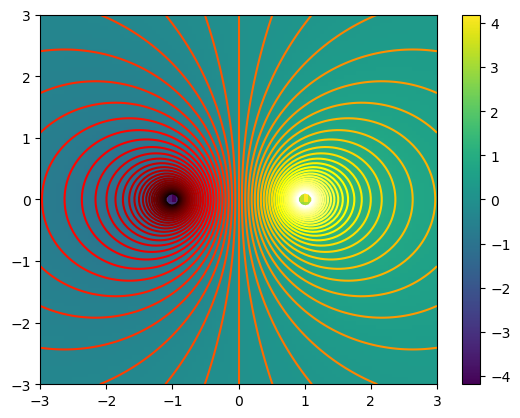

In [7]:
V_xy = potential(coord_x, coord_y, a, C)
plt.figure()
plt.pcolormesh(coord_x, coord_y, V_xy)
plt.colorbar()
# plt.contour(coord_x, coord_y, V_xy, np.sort([-1 , 0 , 1]), cmap='hot')
plt.contour(coord_x, coord_y, V_xy, np.sort([0.1*i for i in range(-30,30)]), cmap='hot')

The parameter cmap simply chooses the set of colors which will be used to show the magnitude of the potential

/tmp/ipykernel_4369/1509013266.py:4: RuntimeWarning: divide by zero encountered in log
  V = -C*np.log(neg_b/a) +C*np.log(b/a)


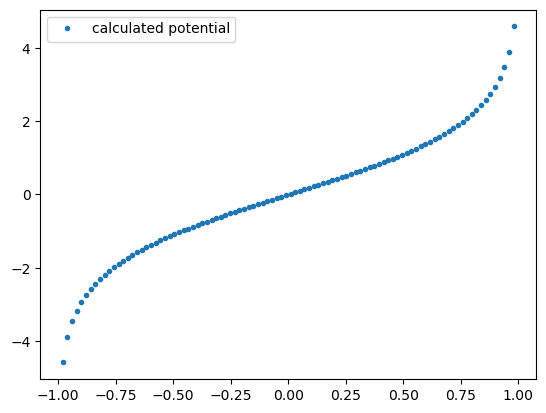

In [8]:
x= np.linspace(-1,1,N)
y = np.zeros(N)

V_x = np.array([potential(x_i, 0, a, C) for x_i in x])

plt.plot(x,V_x, '.')

plt.legend(["calculated potential"])

Capacitor:

In [9]:
eps0 = spc.epsilon_0 # F/m
D = 18e-2 # m
d = 0.5e-3 # m

In [10]:
C_data = pd.read_csv('capacitor.csv')
C_data = C_data.rename(columns = {"time (sec)":"t", "ch2":"V_R"})
C_data["V_C"] = C_data["ch1"] - C_data["V_R"]
print(C_data)

            t       ch1       V_R       V_C
0    0.000000  3.858477 -0.081709  3.940186
1    0.000000  3.793352 -0.080584  3.873936
2    0.000001  3.706517 -0.080584  3.787101
3    0.000001  3.641392 -0.081146  3.722538
4    0.000002  3.576266 -0.080021  3.656287
..        ...       ...       ...       ...
415  0.000166 -0.049060  0.000462 -0.049522
416  0.000166 -0.049060  0.001587 -0.050647
417  0.000167 -0.049060  0.002150 -0.051210
418  0.000167 -0.070769 -0.000101 -0.070668
419  0.000168 -0.049060 -0.000664 -0.048396

[420 rows x 4 columns]


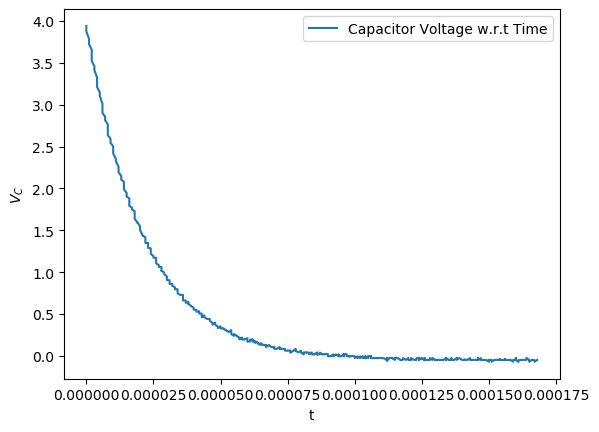

In [11]:
plt.plot(C_data["t"], C_data["V_C"])
plt.legend(["Capacitor Voltage w.r.t Time"])
plt.xlabel("t"), plt.ylabel("$V_{C}$")

t = np.array(C_data['t'].values)
V_C = np.array(C_data['V_C'].values)

Curve fitting is the process of constructing a curve that is required to best fit a series of datapoints, and possibly some other constraints (e.g: must be linear)

In [12]:
def V_decay(t,tau,V0):
    return V0*np.exp(-t/tau)

p_optimal, p_covariance = cfit(V_decay,C_data['t'], C_data["V_C"], p0=[2e-5,4])
print(p_optimal)
print(p_covariance)

std = np.sqrt(np.diag(p_covariance))
print(std)

[2.04370871e-05 3.98566190e+00]
[[ 6.43936085e-15 -6.14294640e-10]
 [-6.14294640e-10  1.19951604e-04]]
[8.02456282e-08 1.09522419e-02]


Note: cfit takes in a theoretical curve equation and datapoints, and returns the values of the coefficients of the equation (in our case: $\tau$ and $V_{0}$) which best fit our datapoints, as well as the covarience (a measure of the accuracy of the fit)

Initially, I did not include initial guesses for the values of $\tau_{fit}$ and $V_{0,fit}$, which resulted in a very inaccurate fit (gave back a straight line). After adding initial guesses of $\tau_{fit} = 2\cdot10^{-5}$ and $V_{0,fit} = 4$, the fitted curve matched very closely to the original datapoints.

In our case, we find:

$\tau_{fit} = 2.04370871\cdot10^{-5}$

$V_{0,fit} = 3.98566190$

p_covariance gives the variance of the coefficient estimates. We find:

$Cov_{\tau_{fit}} = [ 6.43936085\cdot10^{-15}, -6.14294640\cdot10^{-10}]$

$Cov_{V_{0,fit}} = [-6.14294640\cdot10^{-10},  1.19951604\cdot10^{-4}]$

Using the covariance, we can calculate the standard deviation to measure the error:

$\sigma_{V_{0,fit}} = 8.0245628210\cdot10^{-8}$

$\sigma_{\tau_{fit}} = 1.09522419\cdot10^{-2}$







(Text(0.5, 0, 't'), Text(0, 0.5, '$V_{C}$'))

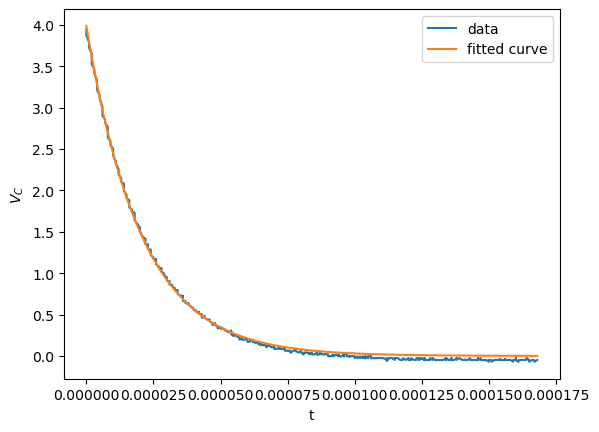

In [13]:
plt.plot(C_data["t"], C_data["V_C"])
plt.plot(C_data['t'], V_decay(C_data['t'],p_optimal[0],p_optimal[1]))
plt.legend(["data", "fitted curve"])
plt.xlabel("t"), plt.ylabel("$V_{C}$")

In [14]:
chi2 = sum([((C_data["V_C"][i]-V_decay(C_data['t'][i],p_optimal[0],p_optimal[1]))/0.05)**2 for i in range(len(C_data["V_C"]))])
print(chi2)

267.51057402488107


In [15]:
dof = len(C_data["V_C"])-2
print(dof)

418


In [16]:
one_minus_p = scipy.stats.chi2.cdf(chi2, dof)
p = 1-one_minus_p
print(p)

0.9999999988996999


In [17]:
r2_score(C_data["V_C"], V_decay(C_data['t'],p_optimal[0],p_optimal[1]))

0.9979397074079406

We find an $r^2$ score of ~0.998. This makes sense when we visually compare the 2 plots, where it is clear the fitted curve closely matches the data-points

/usr/lib/python3/dist-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, '$log(V_{c})$')

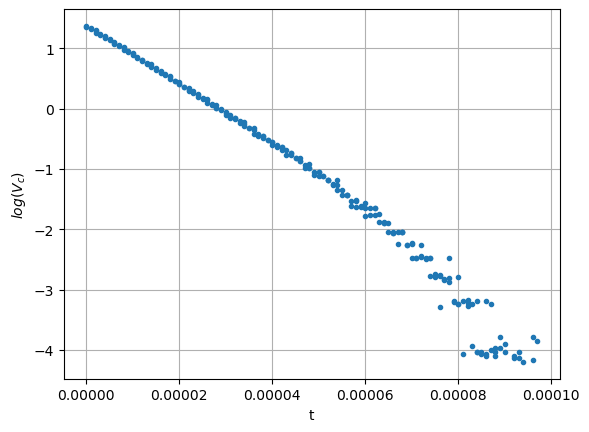

In [18]:
plt.plot(C_data["t"], np.log(C_data["V_C"]), ".")
plt.grid()
plt.xlabel("t")
plt.ylabel("$log(V_{c})$")

After plotting the graph above, we see a clear linear range from $t = (0,0.00005) [s]$

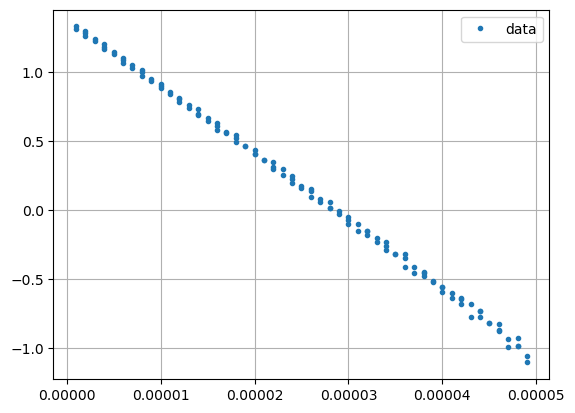

In [19]:
t1,t2 = 0, 0.00005
inds = (C_data['t'] > t1) & (C_data['t'] < t2)
plt.plot(C_data['t'][inds], np.log(C_data["V_C"])[inds],'.', label="data")
plt.legend()
plt.grid()

Linear regression is curve fitting where the function we wish to fit is linear. 

In [20]:
reg = linregress(C_data['t'][inds], np.log(C_data["V_C"])[inds])
print(reg)

LinregressResult(slope=-48897.61873817055, intercept=1.3893945941307775, rvalue=-0.9994032478444723, pvalue=2.906451219469254e-177, stderr=154.27783129014054, intercept_stderr=0.004426888468853329)


In [21]:
#We derive the original parameters by applying ln() to V_decay and equating to
#the equation for the line of best fit, y=mx+b, where m=slope, b=y intercept
tau_reg = -1/reg.slope 
V0_reg = np.e**(reg.intercept) 
print(tau_reg, V0_reg)

2.0450893638699385e-05 4.012420174813543


The original parameters were derived by taking the natural logarithm of $V_{decay}$ and equating it to the equation of the line of best fit: $y = m\cdot x +c$.

We find $tau_{reg}=2.045\cdot10^{-5}, V_{0,reg}=4.012$

In [22]:
tau_reg_er = reg.stderr/reg.slope**2
V0_reg_er = reg.intercept_stderr*np.e**(reg.intercept) 

In [23]:
R2_reg = reg.rvalue**2

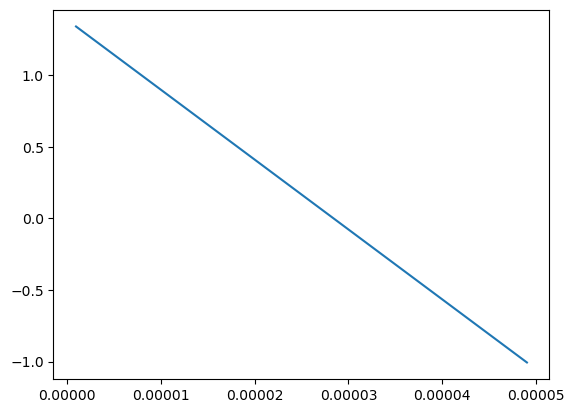

In [24]:
plt.plot(t[inds], t[inds]*reg.slope+reg.intercept)

In [25]:
C_data["int_V_R"] = scipy.integrate.cumtrapz(C_data["V_R"], x = t, initial = 0)

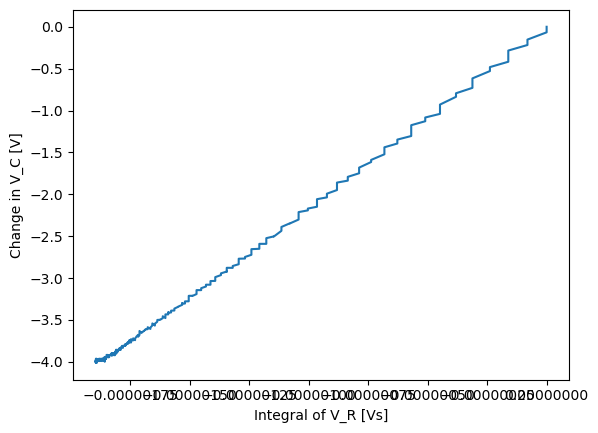

In [26]:
plt.figure()
plt.xlabel('Integral of V_R [Vs]')
plt.ylabel('Change in V_C [V]')
plt.plot(C_data["int_V_R"], C_data["V_C"]-C_data["V_C"][0], label = "V_C as function of integral of V_R")
#The data is linear throughout the entire domain

In [31]:
R = 977
reg2 = scipy.stats.linregress(C_data["int_V_R"], C_data["V_C"]-C_data["V_C"][0])
C_meas = 1/(R*reg2.slope)

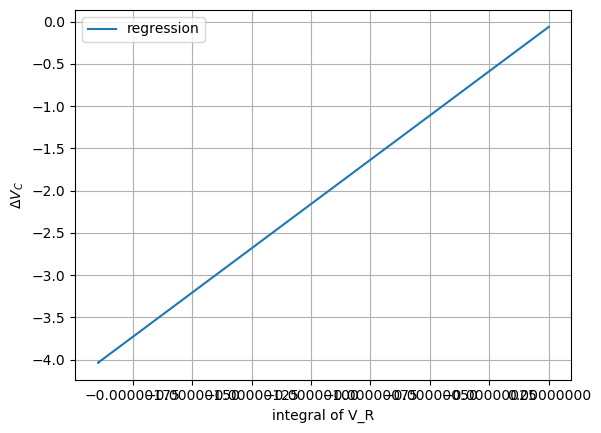

In [33]:
plt.plot(C_data["int_V_R"], C_data["int_V_R"]*reg2.slope+reg2.intercept, label = 'regression')
plt.xlabel("integral of V_R")
plt.ylabel("$\Delta V_C$")
plt.legend()
plt.grid()


Ohm

In [39]:
def I_R(V2, R1):
    return V2/R1
    
def V_R(V1, V2):
    return V1-V2
    
def R_t(V_R, I_R):
    return V_R/I_R
    
def P_t(V_R, I_R):
    return V_R*I_R
    
def Energy(P_t, t):
    return scipy.integrate.cumtrapz(P_t, x=t, initial=0)

In [40]:
R1 = 5.49 #Ohm

In [41]:
R_data=pd.read_csv('ohm.csv', header=1, usecols=[3, 4, 5, 7, 8])

We need the header, as it specifies the row number in which column names will be located.

In [42]:
R_data = R_data.rename(columns = {"Time (s)":"t", "1 (VOLT)":"V1", "2 (VOLT)":"V2"})

In [43]:
V = V_R(R_data["V1"], R_data["V2"])


In [44]:
I = I_R(R_data["V2"], R1)

In [45]:
R = R_t(V, I)

In [46]:
E = Energy(P_t(V, I), R_data["t"])

Text(0, 0.5, 'Resistance [Ohm]')

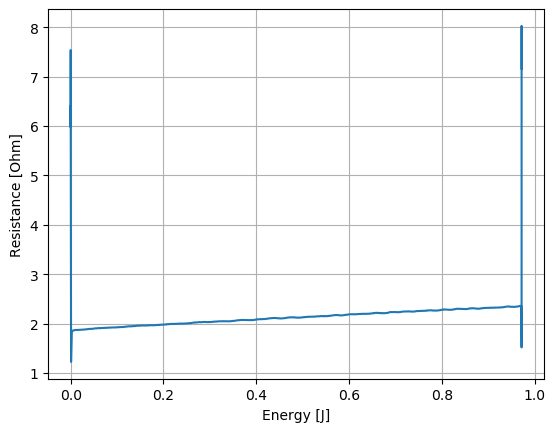

In [47]:
plt.figure()
plt.grid()
plt.plot(E, R)
plt.xlabel("Energy [J]")
plt.ylabel("Resistance [Ohm]")

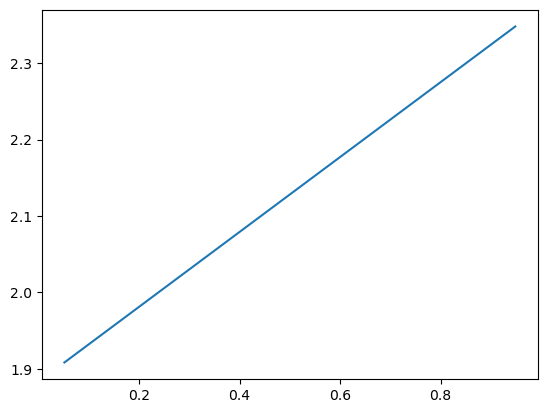

In [48]:
inds = (E > 0.05) & (E < 0.95)
reg3 = scipy.stats.linregress(E[inds], R[inds])
plt.plot(E[inds], E[inds]*reg3.slope+reg3.intercept)

In [50]:
R0 = reg3.intercept 
alpha_C_heat = reg3.slope/R0 
print(R0, alpha_C_heat)

1.8831628897864683 0.26022611309975646


After comparing with fellow students, this result seems correct, as it was close to their answers

In [51]:
def flux(voltage, time):
   return scipy.integrate.cumtrapz(voltage, x=time, initial = 0)


In [52]:
h = np.array([0.3, 0.24, 0.18, 0.14, 0.08])

In [53]:
Ind_data = []
for n in range(0,5):
    df = pd.read_csv('Trace %d.csv'%n, header = 1, usecols=[3, 4, 5])
    df = df.rename(columns = {"Time (s)":"t", "1 (VOLT)":"ref", "2 (VOLT)":"signal"})
    Ind_data.append(df)

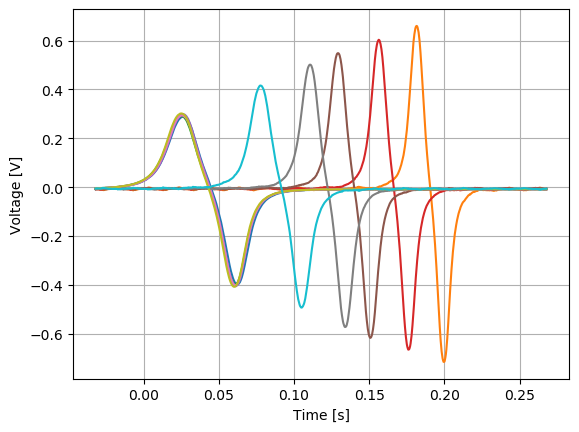

In [54]:
plt.figure()
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
for df in Ind_data:
    plt.plot(df["t"], df["ref"])
    plt.plot(df["t"], df["signal"])

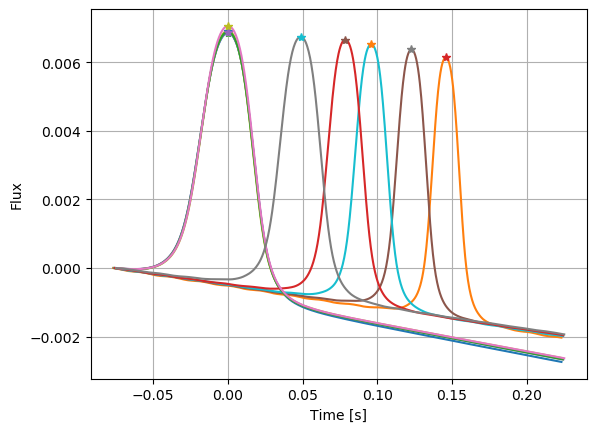

In [55]:
t_coil = []
plt.figure()
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Flux")
for df in Ind_data:
    f_ref =     flux(df["ref"], df["t"])
    ind_max_ref = np.argmax(np.abs(f_ref))
    df["t"] -= df["t"][ind_max_ref]
    f_signal = flux(df["signal"], df["t"])
    ind_max_signal = np.argmax(np.abs(f_signal))
    t_coil.append(df["t"][ind_max_signal])
    plt.plot(df["t"], f_ref)
    plt.plot(df["t"], f_signal)
    plt.plot(df["t"][ind_max_ref], f_ref[ind_max_ref],'*')
    plt.plot(df["t"][ind_max_signal], f_signal[ind_max_signal],'*')

Text(0, 0.5, 'h/t_coil [ms^-1]')

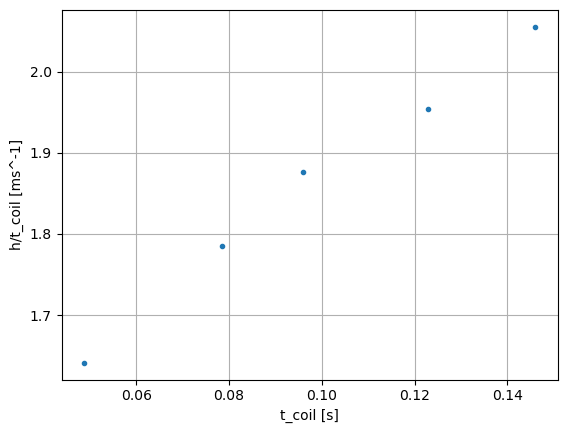

In [56]:
y = h/t_coil
plt.figure()
plt.grid()
plt.plot(t_coil, y,'.')
plt.xlabel("t_coil [s]")
plt.ylabel("h/t_coil [ms^-1]")

In [58]:
h_error = 0.001
t_coil_error = 0.002

Calculate the propagated error as follows:
$y_{error}^{2} = ((\frac{\delta y}{\delta h})\cdot(h_{error}))^2+((\frac{\delta y}{\delta t_{coil}})\cdot(t_{coil, error}))^2$


<ErrorbarContainer object of 3 artists>

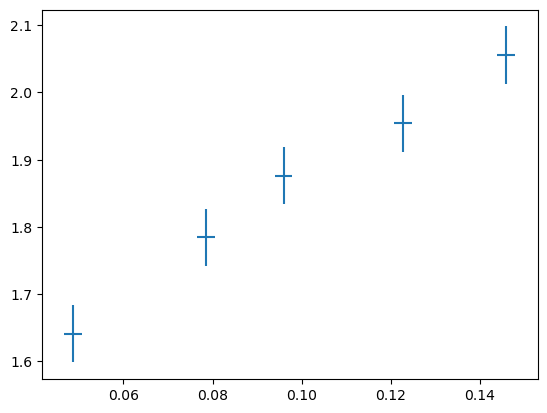

In [59]:
y_error = 0.0425
plt.errorbar(t_coil, y, y_error, t_coil_error, ls = 'none')

In [61]:
reg4 = scipy.stats.linregress(t_coil, y)
v_0 = reg4.intercept
a = 2*reg4.slope
print(a)

8.36050314800611


We can see that a is reasonable close to $g \approx 9.81 [\frac{m}{s^2}]$

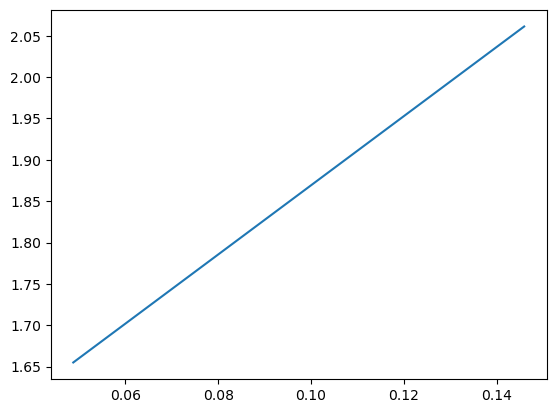

In [62]:
y_reg = np.array(t_coil)*reg4.slope+reg4.intercept
plt.plot(np.array(t_coil), y_reg)

In [63]:
R2_reg4 = reg4.rvalue**2
print(R2_reg4)

0.9906697305222613


In [65]:
chi2_coil = np.sum(((y_reg-y)/y_error)**2)
dof_coil = len(y)-2
one_minus_p_coil = scipy.stats.chi2.cdf(chi2_coil, dof_coil)
p = 1 - one_minus_p_coil
print(p)

0.914103468537448
